# Step-by-step guide

This guide shows step by step how a compartmental model is built and how its
parameter can by inferred.

First some imports

In [2]:
import time

import arviz as az
import jax
import jax.numpy as jnp
import jaxopt
import matplotlib.pyplot as plt
import numpy as np
import optax
import pymc as pm
import pytensor.tensor as pt
from tqdm.auto import tqdm

import icomo

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Let us first define a system of ordinary differential equations (ODEs). As an example, we will make an SEIR model with an Erlang distributed latent period.

In [3]:
# ODEs should always be defined with t, y and args, t is the time variable, y the
# variables proper and args the other arguments.
# t is a float, y and args any python structure (dict, tuple, lists) containing arrays,
# or for args potentially a function.
def Erlang_SEIR(t, y, args):
    # y and the args are passed as dictionary in this example to facilite
    # keeping track of the meaning of the variables
    N = args["N"]

    # beta is here time-dependent, so we pass a function which will be evaluated at t
    beta_t_func = args["beta_t_func"]

    dy = {}  # Create the return dictionary of the derivatives, it will have the same
    # structure as y

    # The derivative of the S compartment is -beta(t) * I * S / N
    dy["S"] = -beta_t_func(t) * y["I"] * y["S"] / N

    # Latent period, use an helper function
    dEs, outflow = icomo.erlang_kernel(
        inflow=beta_t_func(t) * y["I"] * y["S"] / N,
        comp=y["Es"],  # y["Es"] is assumed to be a list of compartments/variables to
        # be able to model the kernel
        rate=args["rate_latent"],
    )
    dy["Es"] = dEs

    dy["I"] = outflow - args["rate_infectious"] * y["I"]

    dy["R"] = args["rate_infectious"] * y["I"]

    return dy  # return the derivatives


def SEIR(t, y, args):
    # y and the args are passed as dictionary in this example to facilite
    # keeping track of the meaning of the variables
    N = args["N"]

    # beta is here time-dependent, so we pass a function which will be evaluated at t
    beta_t_func = args["beta_t_func"]

    dy = {}  # Create the return dictionary of the derivatives, it will have the same
    # structure as y

    # The derivative of the S compartment is -beta(t) * I * S / N
    dy["S"] = -beta_t_func(t) * y["I"] * y["S"] / N

    # Latent period, use an helper function
    dE = beta_t_func(t) * y["I"] * y["S"] / N - args["rate_latent"] * y["Es"]

    dy["Es"] = dE

    dy["I"] = args["rate_latent"] * y["Es"] - args["rate_infectious"] * y["I"]

    dy["R"] = args["rate_infectious"] * y["I"]

    return dy  # return the derivatives

The above function defined the following set of equations:
$$ \begin{align}
\frac{\mathrm dS(t)}{\mathrm dt} &= -\tfrac{1}{N}{\beta(t)}SI,\\
\frac{\mathrm dE^{(1)}(t)}{\mathrm dt} &= \tfrac{1}{N}\beta(t) SI-\mathrm{rate_latent} \cdot n \cdot E^{(1)},\\
\frac{\mathrm dE^{(2)}(t)}{\mathrm dt} &= \mathrm{rate_latent} \cdot n \cdot E^{(1)} -\mathrm{rate_latent} \cdot n \cdot E^{(2)},\\
\frac{\mathrm dE^{(3)}(t)}{\mathrm dt} &= \mathrm{rate_latent} \cdot n \cdot E^{(2)} -\mathrm{rate_latent} \cdot n \cdot E^{(3)},\\
\frac{\mathrm dI(t)}{\mathrm dt} &= \mathrm{rate_latent} \cdot n \cdot E^{(3)} -\mathrm{rate_infectious} \cdot  I,\\
\frac{\mathrm dR(t)}{\mathrm dt} &=\mathrm{rate_infectious} \cdot  I,,
\end{align} $$
Here $n = 3$ is the number of exposed compartments $E$. In the function above the exposed compartments are saved as list in `y["Es"]`.
The three equations $\frac{\mathrm dE^{(1 \dots 3)}(t)}{\mathrm dt}$ are defined in the [icomo.erlang_kernel](api/references.rst#icomo.erlang_kernel) function for convenience. This function also sets dynamically $n$ to the length of the list `y["Es"]`.
Take care to only use jax operations inside the differential equation, for instance `jnp.cos` instead of `np.cos`.
It will be compiled with jax later and would otherwise lead to an error.

## Integrating ODEs

Given some starting conditions and parameters we can integrate our system of ODEs:

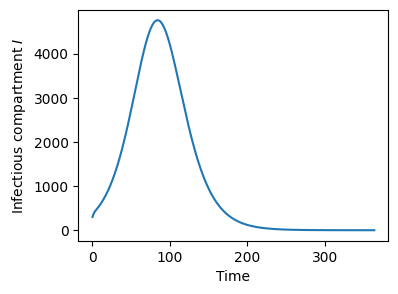

In [15]:
len_sim = 365  # days
num_points = len_sim

### First set the time variables
t_out = np.linspace(0, len_sim, num_points)  # timepoints of the output
t_beta = np.linspace(
    0, len_sim, num_points // 14
)  # timepoints at which the time-dependent
# variable is defined (every 2 weeks)

### Define parameters
N = 1e5  # population
R0 = 1.5
duration_latent = 3  # the average in days
duration_infectious = 7  # the average in days
beta0 = R0 / duration_infectious  # infection rate


### Set parameters  for ODE
args = {
    "N": N,
    "rate_latent": 1 / duration_latent,
    "rate_infectious": 1 / duration_infectious,
}


### Define starting conditions
y0 = {
    "Es": np.array([100, 100, 100]),  # multiple values to model the Erlang kernel
    "I": 300,
    "R": 0,
}  # It is important that the Es for the Erlang-kernel is a numpy or jax array, not a
# list, as otherwise it is interpreted as separate compartments.


# Susceptible compartment is N - other compartments
y0["S"] = N - y0["R"] - np.sum(y0["Es"])

# We want to have a time-dependent beta. As the system of ODEs requires a value of beta
# for any t, we define a interpolation function that can be evaluated at arbitrary t.

beta_t_func = icomo.interpolate_func(
    ts_in=t_beta,
    # assume constant beta for now
    values=beta0 * np.ones(len(t_beta)),
)
args["beta_t_func"] = beta_t_func


# Solve differential equation,
solution = icomo.diffeqsolve(
    ts_out=t_out,
    y0=y0,
    args=args,
    ODE=Erlang_SEIR,
)

f = plt.figure(figsize=(4, 3))
plt.plot(solution.ys["I"])
plt.xlabel("Time")
plt.ylabel("Infectious compartment $I$");

We here use an ODE integrator built with the [icomo.ODEIntegrator](api/references.rst#icomo.ODEIntegrator) which wraps the ODE  solver from [Diffrax](https://docs.kidger.site/diffrax/). In general, the `constant_args` and variables `y0` passed to the integrator and subsequently
to the ODE function can be a any nested list, tuple and/or dict, which is also called [pytree](https://jax.readthedocs.io/en/latest/pytrees.html). The output will have the same structure as `y0` except that its variables will received a prependet time dimension.
`arg_t` has to be an ndimensional array, where the first dimension matches the length of `ts_arg`.

## Simplify the construction of ODEs with `icomo.CompModel`
The system of ODEs can by vastly simplified. Notice how the population subtracted from one compartment is always added exactly to another compartment.
Furthermore, the substracted amount is always proportional to the population currently in the compartment. Making use of these two properties, one can specify such a system by a number of flows starting and ending in different compartments and parametrized by rates which are multiplied by the starting
compartment. Such a spefication is possible with the class [icomo.CompModel](api/references.rst#icomo.CompModel):

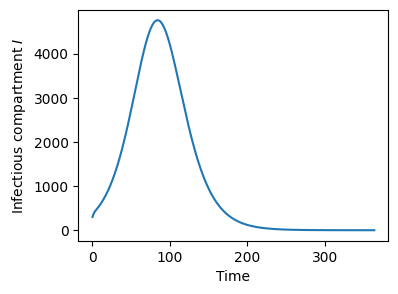

In [5]:
comp_model = icomo.CompModel()


def Erlang_SEIR_v2(t, y, args):
    beta_t_func = args["beta_t_func"]
    comp_model.y = y
    comp_model.flow(
        start_comp="S",
        end_comp="Es",
        rate=y["I"] / args["N"] * beta_t_func(t),
        label="beta(t) * I/N",  # label of the graph edge
        end_comp_is_erlang=True,
    )  # One has to specify that "Es" refers to
    # an array of compartments
    comp_model.erlang_flow("Es", "I", args["rate_latent"], label="rate_latent (erlang)")
    comp_model.flow("I", "R", args["rate_infectious"], label="rate_infectious")
    return comp_model.dy


# Check whether the resulting dynamics are the same as the previous version
solution = icomo.diffeqsolve(
    ts_out=t_out,
    y0=y0,
    args=args,
    ODE=Erlang_SEIR_v2,
)

f = plt.figure(figsize=(4, 3))
plt.plot(solution.ys["I"])
plt.xlabel("Time")
plt.ylabel("Infectious compartment $I$");

Take notice that CompModel assumes that the variables/compartments `y` are saved in a dictionary and that for flow that follow and Erlang kernels, the corresponding compartments are in a list saved under the key of `start_comp`.

Another advantage is the a `CompModel` object can display the graph with the `view_graph()` method, which helps the verify the parametrisation was correct.
Specify in this case the `label` keyword when adding flows, these are displayed on the edges of the graph.

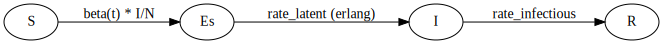

In [6]:
comp_model.view_graph()

Another advantage is the a `CompModel` object can display the graph with the `view_graph()` method, which helps the verify the parametrisation was correct.
Specify in this case the `label` keyword when adding flows, these are displayed on the edges of the graph.



## Fitting/optimizing the model using Data

We might to optimize some parameters of the model. This is readily achieved as it can be easily differenciated using [jax.grad](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html#taking-derivatives-with-grad).

Concretely, we will optimize the `beta_t` variable. We defined it every 14 days. The
[icomo.ODEIntegrator](api/references.rst#icomo.ODEIntegrator) class uses a cubic
interpolation to obtain a continuous approximation inbetween. For completeness, we
will also need to optimize the initial number of infected `I0`.

In [7]:
# Data are the number of COVID-19 cases in England during 2022
data = [236576, 188567, 118275, 181068, 229901, 275647, 222174, 172980, 120287, 93615, 95790, 132959, 115245, 103219, 96412, 86325, 77950, 98097, 131514, 118857, 111760, 100324, 91730, 81733, 102365, 127364, 113201, 108668, 96200, 84026, 73512, 87702, 105051, 93949, 88418, 76644, 63264, 52305, 60552, 76483, 69661, 64339, 52293, 44559, 37529, 41755, 54745, 52502, 51572, 44716, 33241, 34647, 37720, 45131, 39188, 36476, 30631, 27837, 25089, 31360, 44649, 44795, 46179, 43761, 41408, 38759, 49026, 68520, 70111, 73531, 70510, 67030, 62078, 75738, 99832, 93708, 91752, 82853, 75285, 67417, 81054, 109286, 99095, 94185, 82905, 72430, 61456, 68336, 92857, 80126, 73643, 54791, 47462, 37592, 42179, 53727, 49101, 44750, 38709, 32988, 27885, 30952, 37371, 33771, 31685, 26638, 21615, 19924, 20144, 25223, 25772, 21457, 18464, 15703, 13210, 14715, 17108, 14560, 13055, 11608, 10012, 8354, 9034, 11907, 13318, 11672, 10221, 8954, 7517, 9062, 10702, 9748, 8725, 7642, 6942, 6120, 7973, 9417, 8286, 7638, 6820, 5821, 5019, 5997, 7313, 6679, 6293, 5753, 5409, 4988, 5680, 7115, 7093, 7011, 6209, 6635, 7492, 9815, 11747, 11411, 11784, 11319, 10784, 10077, 12693, 15272, 15141, 14837, 14225, 13919, 13623, 16997, 19942, 20896, 20873, 19590, 18349, 16800, 20778, 25104, 25041, 24601, 24240, 23650, 21961, 27780, 33704, 31415, 29698, 26454, 24611, 21246, 25096, 29826, 26946, 23856, 21100, 18359, 15017, 17236, 18718, 16670, 16169, 14158, 12378, 9934, 11275, 13299, 11725, 10544, 9329, 8508, 7325, 8426, 9835, 9170, 8353, 7296, 6548, 5420, 6547, 8068, 7309, 6748, 6193, 5339, 4495, 5363, 6424, 5559, 5032, 4564, 4012, 3502, 4085, 5224, 4778, 4554, 3796, 3451, 3112, 3439, 4662, 5226, 4615, 4350, 3808, 3417, 4288, 5125, 4578, 4235, 3747, 3553, 3268, 4347, 5307, 5147, 4973, 4634, 4134, 3521, 4339, 6166, 7828, 7553, 6815, 6485, 5719, 7240, 8617, 8251, 8414, 7895, 7615, 7065, 9204, 11692, 10965, 10231, 9389, 8950, 7053, 8558, 10497, 9461, 8768, 8134, 7970, 6442, 7780, 10002, 8233, 7598, 6576, 6297, 4968, 5523, 6807, 5665, 5449, 4855, 4401, 3583, 4271, 5130, 4549, 4014, 3678, 3107, 2665, 3267, 4321, 3829, 3576, 3205, 2893, 2433, 2912, 3923, 3534, 3260, 3037, 2773, 2430, 2890, 3937, 3805, 3616, 3329, 2902, 2551, 3448, 4639, 4386, 3980, 3505, 3596, 2748, 3786, 5325, 5241, 5195, 4537, 4216, 3570, 4631, 6986, 7111, 6533, 6094, 6084, 4743, 5772, 9073, 8631, 7802, 6877, 5741, 4132, 3694, 4950, 6605, 8419, 7718]  # noqa E501 # fmt: skip
data = np.array(data)
N_England = 50e6


# Setup a function that simulate the spread given a time-dependent beta_t and the
# initial infected I0
def simulation(args_optimization):
    beta_t = args_optimization["beta_t"]

    # Spread out the infected over the exposed and infectious compartments
    I0 = args_optimization["I0"] / 2
    Es_0 = args_optimization["I0"] / 6 * jnp.ones(3)

    # Update const_args
    args["N"] = N_England

    # Update starting conditions
    y0 = {
        "Es": Es_0,
        "I": I0,
        "R": 0,
    }
    y0["S"] = N_England - jnp.sum(y0["Es"]) - y0["I"] - y0["R"]

    # beta is now time-dependent
    beta_t_func = icomo.interpolate_func(ts_in=t_beta, values=beta_t)
    args["beta_t_func"] = beta_t_func

    output = icomo.diffeqsolve(
        ts_out=t_out,
        y0=y0,
        args=args,
        ODE=Erlang_SEIR_v2,
        # fixed_step_size=True,
        # dt0 = (t_out[1]-t_out[0])*2,
        # dt0=None,
        # stepsize_controller = diffrax.StepTo(ts=t_solve_ODE),
    ).ys

    # Save also the beta at the output times
    beta_t_interpolated = beta_t_func(t_out)
    output["beta_t_interpolated"] = beta_t_interpolated

    return output


# Define our loss function
@jax.jit
def loss(args_optimization):
    output = simulation(args_optimization)
    new_infected = -jnp.diff(
        output["S"]
    )  # The difference in the susceptible population
    # are the newly infected

    # Use the mean squared difference as our loss, weighted by the number of new
    # infected
    loss = jnp.mean((new_infected - data[1:]) ** 2 / (new_infected + 1))
    # Notice the use of jax.numpy instead of number for the calculation. This is
    # necessary. as it allows the auto-differentiation of our loss function.

    return loss


# Define initial parameters
init_params = {
    "beta_t": beta0 * np.ones_like(t_beta),
    "I0": np.array(float(data[0] * duration_infectious)),
}  # np.arrays are used here, as ScipyMinimize passes converts it to np.arrays anyway,
# and as we want to compile it beforehand for runtime measurements, it would otherwise
# elicit a recompilation when called by jaxopt.ScipyMinimize

start_time = time.time()
# Differenciate our loss
value_and_grad_loss = jax.jit(jax.value_and_grad(loss))
value_and_grad_loss(init_params)
print(f"Compilation duration: {(time.time()-start_time):.1f}s")

### Solve our minimization problem
solver = jaxopt.ScipyMinimize(
    fun=value_and_grad_loss, value_and_grad=True, method="L-BFGS-B", jit=False
)

start_time = time.time()
res = solver.run(init_params)
end_time = time.time()
print(f"Minimization duration: {(end_time-start_time):.3f}s")

print(
    f"Number of function evaluations: {res.state.iter_num}\n"
    f"Final cost: {res.state.fun_val:.3f}"
)

Compilation duration: 18.3s
Minimization duration: 1.047s
Number of function evaluations: 147
Final cost: 1138.302


We decided here to use [jaxopt.ScipyMinimize](https://jaxopt.github.io/stable/_autosummary/jaxopt.ScipyMinimize.html) as minimization function, which wraps the [scipy.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize) function. The advantage to scipy.minimize is that we can use pytrees as optimization variables instead flat arrays. Otherwise scipy.minimize works equally
well.

In order to speed up the fitting procedure, we compile our loss function using [jax.jit](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html#using-jit-to-speed-up-functions),
a just-in-time (jit) compiler. This improves the runtime of the minimization by about a factor 20.

Notice the use of jax.numpy inside the loss function but not outside. It is a good habit
to only use jax.numpy for calculations that needs to be automatically differentiated and
otherwise the usual numpy. It might avoid the unnecessary tracing/graph-building of such
variables and can also lead to errors if function still depend on traced variables outside
the current scope.

Let us check the results:

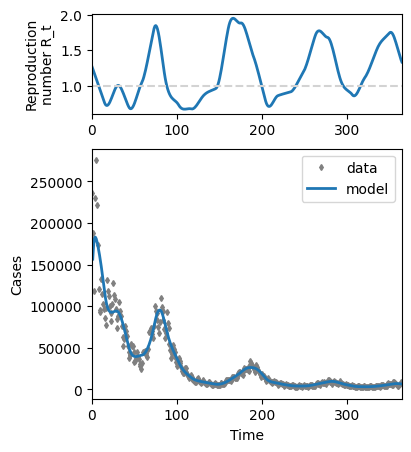

In [8]:
f, axes = plt.subplots(2, 1, figsize=(4, 5), height_ratios=(1, 2.5))
plt.sca(axes[0])
plt.plot(
    t_out[:],
    simulation(res.params)["beta_t_interpolated"] * duration_infectious,
    color="tab:blue",
    label="model",
    lw=2,
)
plt.ylabel("Reproduction\nnumber R_t")
plt.xlim(t_out[0], t_out[-1])
plt.axhline([1], color="lightgray", ls="--")
plt.sca(axes[1])
plt.plot(t_out, data, color="gray", ls="", marker="d", ms=3, label="data")
plt.plot(
    t_out[1:],
    -np.diff(simulation(res.params)["S"]),
    color="tab:blue",
    label="model",
    lw=2,
)
plt.xlabel("Time")
plt.ylabel("Cases")
plt.legend()
plt.xlim(t_out[0], t_out[-1]);

### Fitting using Adam

For high-dimensional optimization systems that are significantly underdetermined it
might be advantageous to use a gradient descent algorithm instead of L-BFGS. This is not
the case for this system, but we show it here as an example using [optax](https://optax.readthedocs.io/en/latest/):

  0%|          | 0/2000 [00:00<?, ?it/s]

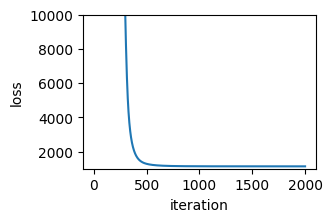

In [9]:
start_learning_rate = 5e-2
schedule = optax.exponential_decay(
    init_value=start_learning_rate,
    transition_steps=1000,
    decay_rate=1 / 2,
    transition_begin=50,
    staircase=False,
    end_value=None,
)
optimizer = optax.adam(learning_rate=schedule)
# Initialize parameters of the model + optimizer.
opt_state = optimizer.init(init_params)
losses = []
params_adam = init_params
for i in (pbar := tqdm(range(2000))):
    func_val, grads = value_and_grad_loss(params_adam)
    if i % 10 == 0:
        pbar.set_description(f"Loss {func_val:.5f}")
    losses.append(func_val)
    updates, opt_state = optimizer.update(grads, opt_state)
    params_adam = optax.apply_updates(params_adam, updates)

f = plt.figure(figsize=(3, 2))
plt.plot(losses)
plt.ylim(1e3, 1e4)
plt.xlabel("iteration")
plt.ylabel("loss");

We obtain similar results:

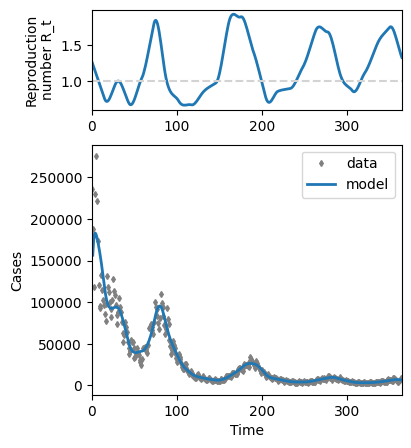

In [10]:
f, axes = plt.subplots(2, 1, figsize=(4, 5), height_ratios=(1, 2.5))
plt.sca(axes[0])
plt.plot(
    t_out[:],
    simulation(params_adam)["beta_t_interpolated"] * duration_infectious,
    color="tab:blue",
    label="model",
    lw=2,
)
plt.ylabel("Reproduction\nnumber R_t")
plt.xlim(t_out[0], t_out[-1])
plt.axhline([1], color="lightgray", ls="--")

plt.sca(axes[1])
plt.plot(t_out, data, color="gray", ls="", marker="d", ms=3, label="data")
plt.plot(
    t_out[1:],
    -np.diff(simulation(params_adam)["S"]),
    color="tab:blue",
    label="model",
    lw=2,
)
plt.xlabel("Time")
plt.ylabel("Cases")
plt.legend()
plt.xlim(t_out[0], t_out[-1]);

## Bayesian analysis

With fitting procedure one doesn't obtain good error estimates of the fitted parameters.
As such, a Bayesian model helps to estimate the credible interval of the parameters
of interest. Let us make such a model for our system of equations.

The central part is the modelling of the infection rate beta_t. In a bayesian
spirit, we assume that differences between subsequent knots of the spline interpolation
follow an hierarchical model: We assume that the deviation of the size of changes in
infectiousness is similar across the changes. The equations for the
beta_t are therefore:
$$
\begin{align}
\sigma_\beta &\sim HalfCauchy\left(0.2\right),\\
\Delta \beta_i &\sim \mathcal{N\left(0, \sigma_\beta\right)}, \\
\beta_k &= \beta_0 \cdot \exp \left(\sum_i^{k} \Delta \beta_i\right),
\end{align}
$$
where $\beta_k$ defines the k-th spline of the cubic interpolation. Let us define the
model:

In [11]:
# reduce the length of the simulation for runtime reasons
t_out_bayes = np.arange(100)
data_bayes = data[t_out_bayes]
t_solve_ODE_bayes = np.linspace(t_out_bayes[0], t_out_bayes[-1], len(t_out_bayes) // 2)
t_beta_bayes = np.linspace(t_out_bayes[0], t_out_bayes[-1], len(t_out_bayes) // 14)

# We therefore need a new ODEIntegrator object
integrator_object_bayes = icomo.ODEIntegrator(
    ts_out=t_out_bayes,
    ts_solver=t_solve_ODE_bayes,
    ts_arg=t_beta_bayes,
)

with pm.Model(coords={"time": t_out_bayes, "t_beta": t_beta_bayes}) as model:
    # We also allow the other rates of the compartments to vary
    duration_latent_var = pm.LogNormal(
        "duration_latent", mu=np.log(duration_latent), sigma=0.1
    )
    duration_infectious_var = pm.LogNormal(
        "duration_infectious", mu=np.log(duration_infectious), sigma=0.3
    )

    # Construct beta_t
    R0 = pm.LogNormal("R0", np.log(1), 1)
    beta_0_var = 1 * R0 / duration_infectious_var
    beta_t_var = beta_0_var * pt.exp(
        pt.cumsum(icomo.hierarchical_priors("beta_t_log_diff", dims=("t_beta",)))
    )

    # Set the other parameters and initial conditions
    args_var = {
        "N": N_England,
        "rate_latent": 1 / duration_latent_var,
        "rate_infectious": 1 / duration_infectious_var,
    }
    infections_0_var = pm.LogNormal(
        "infections_0", mu=np.log(data_bayes[0] * duration_infectious), sigma=2
    )

    y0_var = {
        "Es": infections_0_var / 3 * np.ones(3),
        "I": infections_0_var / 2,
        "R": 0,
    }
    y0_var["S"] = N_England - pt.sum(y0_var["Es"]) - y0_var["I"] - y0_var["R"]

    beta_t_func = icomo.jax2pyfunc(icomo.interpolate_func)(
        ts_in=t_beta_bayes, values=beta_t_var
    )
    args_var["beta_t_func"] = beta_t_func

    # Define our integrator, notice that we use get_op instead of get_func. get_op
    # returns a pytensor operation that we can use in a pymc object.
    output = icomo.jax2pytensor(icomo.diffeqsolve)(
        ts_out=t_out_bayes,
        y0=y0_var,
        args=args_var,
        ODE=Erlang_SEIR,
    ).ys

    pm.Deterministic("I", output["I"])
    new_cases = -pt.diff(output["S"])
    pm.Deterministic("new_cases", new_cases)

    # And define our likelihood
    sigma_error = pm.HalfCauchy("sigma_error", beta=1)
    pm.StudentT(
        "cases_observed",
        nu=4,
        mu=new_cases,
        sigma=sigma_error * pt.sqrt(new_cases + 1),
        observed=data_bayes[1:],
    )

    # Like before,w we also want to save the interpolated beta_t

    beta_t_interp = icomo.jax2pytensor(lambda f, x: f(x))(
        beta_t_func, pt.as_tensor_variable(t_out_bayes)
    )
    pm.Deterministic("beta_t_interp", beta_t_interp)

And then sample from it. We use the numpyro sampler, as it uses JAX which
is more efficient as our differencial equation solver is written using jax.
The normal pymc sampler also works. It would convert all the model in C,
except our ODE solver, which would still run using JAX.

In [12]:
trace = pm.sample(
    model=model,
    tune=300,
    draws=200,
    cores=2,
    nuts_sampler="numpyro",
    target_accept=0.9,
)
warnings = pm.stats.convergence.run_convergence_checks(
    trace,
    model=model,
)
pm.stats.convergence.log_warnings(warnings)
print(f"Maximal R-hat value: {max(az.rhat(trace).max().values()):.3f}")

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Maximal R-hat value: 1.023


Notice how much longer the sampling takes compared to the simple fitting of the dynamics.
It is also recommended to let it run for longer, to make sure the estimated posterior
distribution converged. Let us plot the inferred parameters:

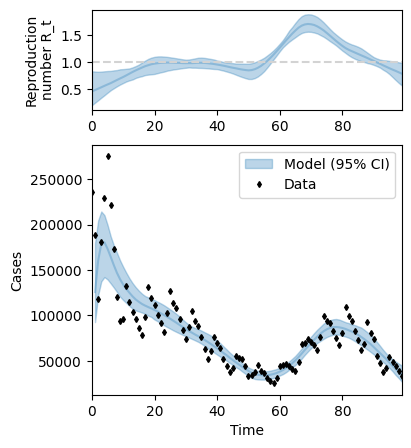

In [13]:
f, axes = plt.subplots(2, 1, figsize=(4, 5), height_ratios=(1, 2.5))
plt.sca(axes[0])
beta_t_post = (
    trace.posterior["beta_t_interp"].to_numpy().reshape((-1, len(t_out_bayes)))
)
R_t_post = (
    beta_t_post * trace.posterior["duration_infectious"].to_numpy().flatten()[:, None]
)
plt.plot(t_out_bayes, np.median(R_t_post, axis=0), color="tab:blue", alpha=0.3)
plt.fill_between(
    t_out_bayes,
    *np.percentile(R_t_post, q=(2.5, 97.5), axis=0),
    color="tab:blue",
    alpha=0.3,
)
plt.ylabel("Reproduction\nnumber R_t")
plt.xlim(t_out_bayes[0], t_out_bayes[-1])
plt.axhline([1], color="lightgray", ls="--")

plt.sca(axes[1])
new_cases_post = (
    trace.posterior["new_cases"].to_numpy().reshape((-1, len(t_out_bayes) - 1))
)
plt.plot(
    t_out_bayes[1:], np.median(new_cases_post, axis=0), color="tab:blue", alpha=0.3
)
plt.fill_between(
    t_out_bayes[1:],
    *np.percentile(new_cases_post, q=(2.5, 97.5), axis=0),
    color="tab:blue",
    alpha=0.3,
    label="Model (95% CI)",
)
plt.plot(t_out_bayes, data_bayes, marker="d", color="black", ls="", ms=3, label="Data")
plt.ylabel("Cases")
plt.xlabel("Time")
plt.xlim(t_out_bayes[0], t_out_bayes[-1])
plt.legend();

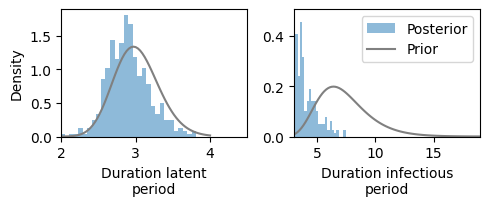

In [14]:
f, axes = plt.subplots(1, 2, figsize=(5, 2.2))
x = np.linspace(1, 4, 100)
plt.sca(axes[0])
plt.hist(
    trace.posterior["duration_latent"].data.flatten(),
    bins=30,
    density=True,
    label="Posterior",
    alpha=0.5,
)
plt.plot(
    x,
    np.exp(pm.logp(pm.LogNormal.dist(np.log(duration_latent), 0.1), x).eval()),
    color="gray",
    label="Prior",
)
plt.xlim(2, 4.5)
plt.xlabel("Duration latent\nperiod")
plt.ylabel("Density")
plt.sca(axes[1])
x = np.linspace(3, 19, 100)
plt.hist(
    trace.posterior["duration_infectious"].data.flatten(),
    bins=30,
    density=True,
    label="Posterior",
    alpha=0.5,
)
plt.plot(
    x,
    np.exp(pm.logp(pm.LogNormal.dist(np.log(duration_infectious), 0.3), x).eval()),
    color="gray",
    label="Prior",
)
plt.xlim(3, 19)
plt.xlabel("Duration infectious\nperiod")
plt.legend()
plt.tight_layout();